# Reference
https://pathmind.com/wiki/lstm

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

https://www.kaggle.com/humamfauzi/multiple-stock-prediction-using-single-nn

https://www.tensorflow.org/tutorials/structured_data/time_series#part_2_forecast_a_multivariate_time_series


# Upload data

In [0]:
from google.colab import files
uploaded = files.upload()

Saving GOOG.csv to GOOG (1).csv


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization, Activation, Input, Flatten, Reshape, concatenate

# Read data

In [0]:
data = pd.read_csv('GOOG.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


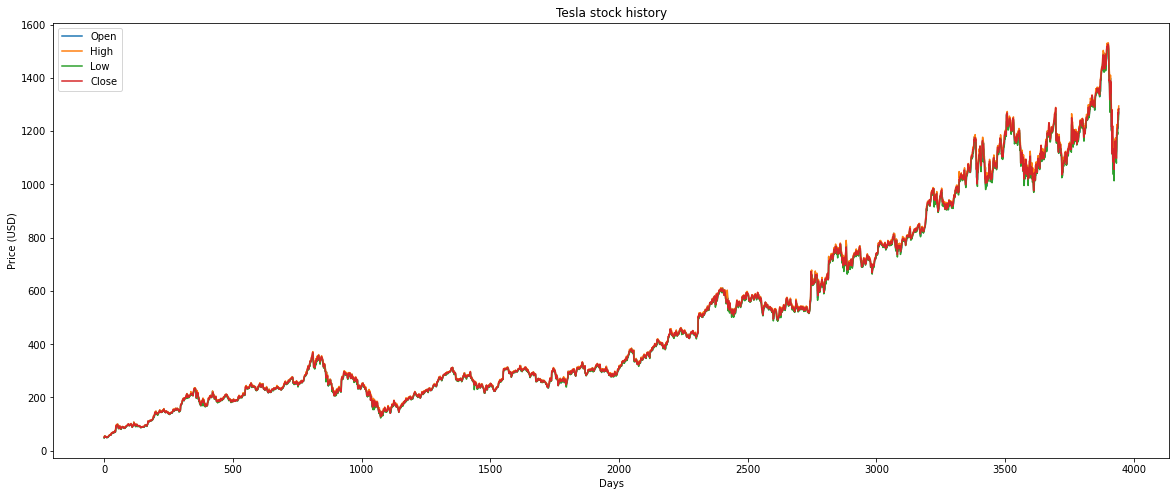

In [0]:
plt.figure(figsize=(20, 8))

plt.plot(data['Open'])
plt.plot(data['High'])
plt.plot(data['Low'])
plt.plot(data['Close'])
plt.title('Tesla stock history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open', 'High', 'Low', 'Close'])

plt.show()

# Feature engineering

In [0]:
def get_technical_indicators(data):
  # Moving average (7 days and 21 days)
  data['ma7'] = data['Close'].rolling(window=7).mean()
  data['ma21'] = data['Close'].rolling(window=21).mean()

  # Create MACD
  mod_close = data['Close'].copy()
  mod_close[0:26] = np.nan
  data['26ema'] = mod_close.ewm(span=26, adjust=False).mean()
  data['12ema'] = mod_close.ewm(span=12, adjust=False).mean()
  data['MACD'] = (data['12ema'] - data['26ema'])

  # Create Bollinger Bands (21 days)
  data['std21'] = data['Close'].rolling(window=21).std()
  data['upper_band21'] = data['ma21'] + (data['std21']*2)
  data['lower_band21'] = data['ma21'] - (data['std21']*2)

  # Create Exponential moving average
  data['ema'] = data['Close'].ewm(com=0.5).mean()

  # remove 
  return data

In [0]:
def plot_technical_indicators(dataset, last_days):
  plt.figure(figsize=(16, 10), dpi=100)
  shape_0 = dataset.shape[0]
  xmacd_ = shape_0-last_days

  dataset = dataset.iloc[-last_days:, :]
  x_ = range(3, dataset.shape[0])
  x_ =list(dataset.index)

  # Plot first subplot
  plt.subplot(2, 1, 1)
  plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
  plt.plot(dataset['Close'],label='Closing Price', color='b')
  plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
  plt.plot(dataset['upper_band21'],label='Upper Band', color='c')
  plt.plot(dataset['lower_band21'],label='Lower Band', color='c')
  plt.fill_between(x_, dataset['lower_band21'], dataset['upper_band21'], alpha=0.35)
  plt.title('Technical indicators for Google - last {} days.'.format(last_days))
  plt.ylabel('USD')
  plt.legend()

  # Plot second subplot
  plt.subplot(2, 1, 2)
  plt.title('MACD')
  plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
  plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
  plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')

  plt.legend()
  plt.show()

In [0]:
def split_data(data, feature_col, target_col, train_size=0.8, shuffle=False):
  
  # get data columns
  X = data[feature_col]
  y = data[target_col]
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=shuffle)
  
  print(f'Training set: ({X_train.shape} - {y_train.shape})')
  print(f'Testing set: ({X_test.shape} - {y_test.shape})')

  return (X_train, y_train), (X_test, y_test)

In [0]:
def scale_data(data, scaler=None):
  
  if scaler is None:
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
  else:
    data_scaled = scaler.transform(data)

  return data_scaled, scaler

In [0]:
def split_feature_target(data, lag_days, num_step=1):

  X, y = data
    
  X_splitted = np.array([np.array(X[i: i + lag_days].copy()) for i in range(len(X) - lag_days - num_step + 1)])
  y_splitted = np.array([np.array(y[i + lag_days : i + lag_days + num_step].copy()) for i in range(len(y) - lag_days - num_step + 1)])

  return (X_splitted, y_splitted)

In [0]:
data_technical_indicators = get_technical_indicators(data)

In [0]:
data_technical_indicators = data_technical_indicators.dropna()
data_technical_indicators = data_technical_indicators.reset_index(drop=True)

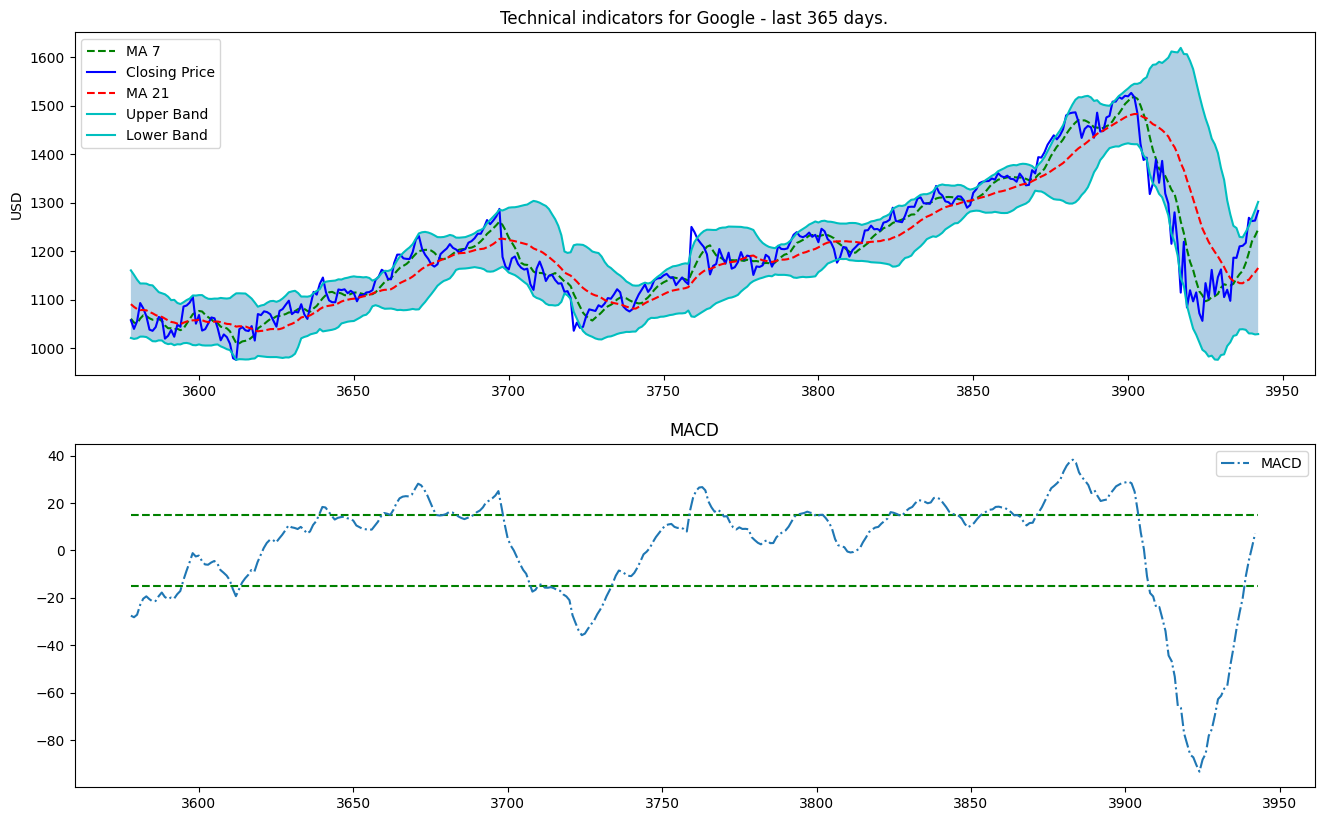

In [0]:
plot_technical_indicators(data, 365)

In [0]:
FEATURE_COL = ['Open', 'High', 'Low', 'Close', 'Volume', 'ma7', 'ma21', '26ema', '12ema', 'MACD', 'std21', 'upper_band21', 'lower_band21', 'ema']
TARGET_COL = ['Close']
LAG_DAYS = 10
NUM_STEP = 5

In [0]:
train_data, test_data = split_data(data_technical_indicators, FEATURE_COL, TARGET_COL, train_size=0.96)

Training set: ((3760, 14) - (3760, 1))
Testing set: ((157, 14) - (157, 1))


In [0]:
train_feature_scaled, feature_scaler = scale_data(train_data[0])
test_feature_scaled, _ = scale_data(test_data[0], scaler=feature_scaler)

train_target_scaled, target_scaler = scale_data(train_data[1])
test_target_scaled, _ = scale_data(test_data[1], scaler=target_scaler)

train_scaled = (train_feature_scaled, train_target_scaled)
test_scaled = (test_feature_scaled, test_target_scaled)

In [0]:
 X_train, y_train = split_feature_target(train_scaled, LAG_DAYS, NUM_STEP)
 X_test, y_test = split_feature_target(test_scaled, LAG_DAYS, NUM_STEP)

In [0]:
print(f'[X_train shape: {X_train.shape} - y_train shape: {y_train.shape}]')
print(f'[X_test shape: {X_test.shape} - y_test shape: {y_test.shape}]')

[X_train shape: (3746, 10, 14) - y_train shape: (3746, 5, 1)]
[X_test shape: (143, 10, 14) - y_test shape: (143, 5, 1)]


# Build Model

In [0]:
INPUT_SHAPE = (LAG_DAYS, len(FEATURE_COL))
OUTPUT_SHAPE = (NUM_STEP)

In [0]:
input_layer = Input(shape=(INPUT_SHAPE), name='lstm_input')
x = LSTM(32, name='lstm_layer_0', return_sequences=True)(input_layer)
x = Flatten()(x)
x = BatchNormalization()(x)
output_layer = Dense(OUTPUT_SHAPE, activation='relu', name='output_layer')(x)

lstm_model = Model(inputs=input_layer, outputs=output_layer, name='lstm_model')

lstm_model.compile(loss='mse', optimizer='rmsprop')

history = lstm_model.fit(X_train, y_train, batch_size=64, epochs=120, validation_split=0.3, use_multiprocessing=True)

Epoch 1/120
41/41 [==============================] - 1s 17ms/step - loss: 0.0296 - val_loss: 0.3604
Epoch 2/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0143 - val_loss: 0.3279
Epoch 3/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0096 - val_loss: 0.2126
Epoch 4/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0075 - val_loss: 0.2531
Epoch 5/120
41/41 [==============================] - 0s 9ms/step - loss: 0.0060 - val_loss: 0.2256
Epoch 6/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0050 - val_loss: 0.2516
Epoch 7/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0043 - val_loss: 0.1990
Epoch 8/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.2046
Epoch 9/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.1498
Epoch 10/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.1775
Epoch 11

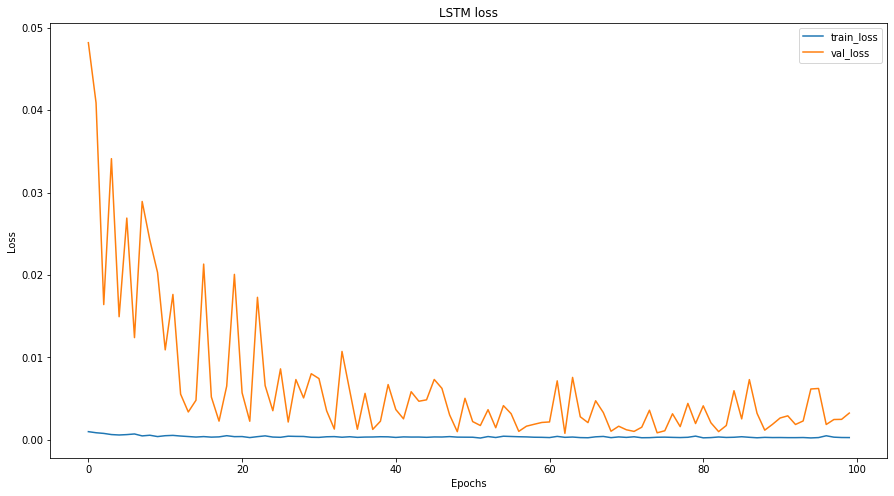

In [0]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 8))

plt.plot(train_loss[20:])
plt.plot(val_loss[20:])

plt.title('LSTM loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'])

plt.show()

In [0]:
lstm_model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 3ms/step - loss: 0.0463


0.046260058879852295

In [0]:
y_test_plot = np.concatenate((y_test[:, 0], y_test[-1, 1:]))
y_test_predict = lstm_model.predict(X_test)

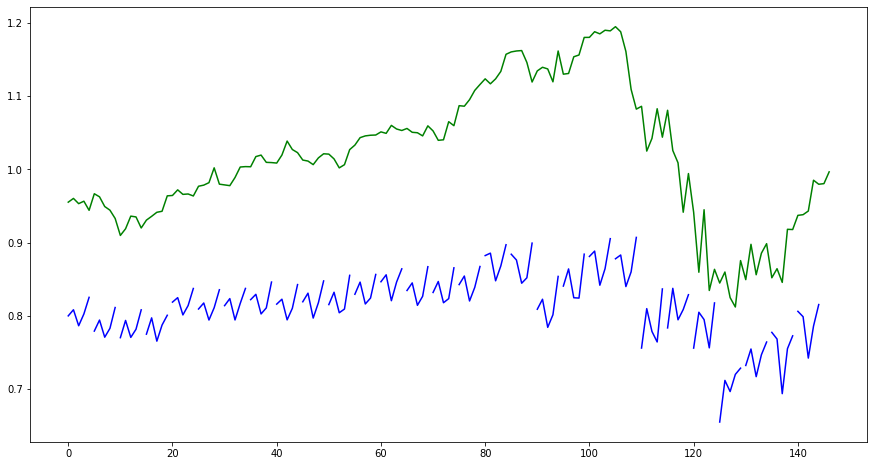

In [0]:
plt.figure(figsize=(15, 8))
plt.plot(y_test_plot, color='g')

for i in range(0, y_test_predict.shape[0], NUM_STEP):
  plt.plot(range(i, i + NUM_STEP), y_test_predict[i], color='b')

plt.show()

Result: The model couldn't capture trend at certain period of time but apparently, captured trend "in general". Meaning the trend will go up a bit the go down, and will go up higher again for most cases. When the stock has high variation as the last 40 days, the model was able to output different trends but the result is still not good. The predicted stock price is also far from the actual prices.

# Using technical indicators as additional input instead of along with stock prices

In [0]:
FEATURE_COL = ['Open', 'High', 'Low', 'Close', 'Volume']
# EXT_FEATURE_COL = ['ma7', 'ma21', '26ema', '12ema', 'MACD', 'std21', 'upper_band21', 'lower_band21', 'ema']
EXT_FEATURE_COL = ['ma7', 'MACD', 'upper_band21', 'lower_band21', 'ema']
TARGET_COL = ['Close']
LAG_DAYS = 10
NUM_STEP = 5

In [0]:
data_technical_indicators = get_technical_indicators(data)
data_technical_indicators = data_technical_indicators.dropna()
data_technical_indicators = data_technical_indicators.reset_index(drop=True)

In [0]:
def split_data(data, feature_col, external_feature_col, target_col, train_size=0.8, shuffle=False):
  
  # get data columns
  X = data[feature_col]
  X_external = data[external_feature_col]
  y = data[target_col]
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=shuffle)
  X_train_external, X_test_external = train_test_split(X_external, train_size=train_size, shuffle=shuffle)
  
  print(f'Training set: ({X_train.shape} - {y_train.shape})')
  print(f'Training set: External data - ({X_train_external.shape})')
  print(f'Testing set: ({X_test.shape} - {y_test.shape})')

  return (X_train, X_train_external, y_train), (X_test, X_test_external, y_test)

In [0]:
train_data, test_data = split_data(data_technical_indicators, FEATURE_COL, EXT_FEATURE_COL, TARGET_COL, train_size=0.96)

Training set: ((3760, 5) - (3760, 1))
Training set: External data - ((3760, 5))
Testing set: ((157, 5) - (157, 1))


In [0]:
def scale_data(data, scalers=None):
  
  X, X_external, y = data

  if scalers is None:
    feature_scaler = MinMaxScaler()
    X_scaled = feature_scaler.fit_transform(X)
    external_feature_scaler = MinMaxScaler()
    X_external_scaled = external_feature_scaler.fit_transform(X_external)
    target_scaler = MinMaxScaler()
    y_scaled = target_scaler.fit_transform(y)
  else:
    feature_scaler, external_feature_scaler, target_scaler = scalers
    X_scaled = feature_scaler.transform(X)
    X_external_scaled = external_feature_scaler.transform(X_external)
    y_scaled = target_scaler.transform(y)

  data_scaled = (X_scaled, X_external_scaled, y_scaled)
  
  return data_scaled, scalers

In [0]:
train_data_scaled, scalers = scale_data(train_data)
test_data_scaled, _ = scale_data(test_data, scalers=scalers)

In [0]:
def split_feature_target(data, lag_days, num_step=1):

  X, X_external, y = data
    
  X_splitted = np.array([np.array(X[i: i + lag_days].copy()) for i in range(len(X) - lag_days - num_step + 1)])
  X_external_splitted = np.array([np.array(X_external[i + lag_days - 1].copy()) for i in range(len(y) - lag_days - num_step + 1)])
  y_splitted = np.array([np.array(y[i + lag_days : i + lag_days + num_step].copy()) for i in range(len(y) - lag_days - num_step + 1)])

  return (X_splitted, X_external_splitted, y_splitted)

In [0]:
 X_train, X_external_train, y_train = split_feature_target(train_data_scaled, LAG_DAYS, NUM_STEP)
 X_test, X_external_test, y_test = split_feature_target(test_data_scaled, LAG_DAYS, NUM_STEP)

In [0]:
print(f'[X_train shape: {X_train.shape} - y_train shape: {y_train.shape}]')
print(f'[X_externel_train shape: {X_external_train.shape} - X_externel_test shape: {X_external_test.shape}]')
print(f'[X_test shape: {X_test.shape} - y_test shape: {y_test.shape}]')

[X_train shape: (3746, 10, 5) - y_train shape: (3746, 5, 1)]
[X_externel_train shape: (3746, 5) - X_externel_test shape: (143, 5)]
[X_test shape: (143, 10, 5) - y_test shape: (143, 5, 1)]


## Without using additional technical indicators

In [0]:
INPUT_SHAPE = (LAG_DAYS, len(FEATURE_COL))
OUTPUT_SHAPE = (NUM_STEP)

In [0]:
input_layer = Input(shape=(INPUT_SHAPE), name='lstm_input')
x = LSTM(32, name='lstm_layer_0', return_sequences=True)(input_layer)
x = Flatten()(x)
x = BatchNormalization()(x)
output_layer = Dense(OUTPUT_SHAPE, activation='relu', name='output_layer')(x)

lstm_model = Model(inputs=input_layer, outputs=output_layer, name='lstm_model')

lstm_model.compile(loss='mse', optimizer='rmsprop')

history = lstm_model.fit(X_train, y_train, batch_size=64, epochs=120, validation_split=0.3, use_multiprocessing=True)

Epoch 1/120
41/41 [==============================] - 1s 17ms/step - loss: 0.0179 - val_loss: 0.2929
Epoch 2/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0063 - val_loss: 0.2496
Epoch 3/120
41/41 [==============================] - 0s 7ms/step - loss: 0.0042 - val_loss: 0.2355
Epoch 4/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0038 - val_loss: 0.2416
Epoch 5/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 0.2372
Epoch 6/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 0.2351
Epoch 7/120
41/41 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.2094
Epoch 8/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.1864
Epoch 9/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.1626
Epoch 10/120
41/41 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.1606
Epoch 11

In [0]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

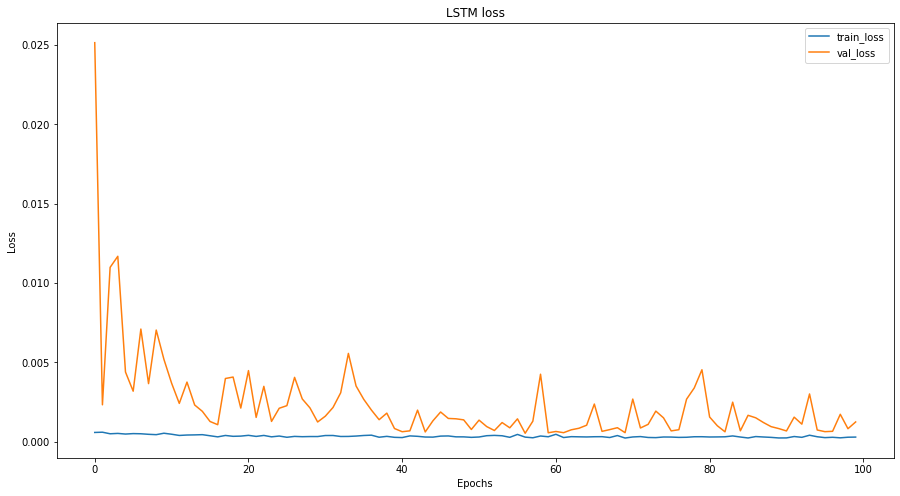

In [0]:
plt.figure(figsize=(15, 8))

plt.plot(train_loss[20:])
plt.plot(val_loss[20:])

plt.title('LSTM loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'])

plt.show()

In [0]:
lstm_model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.0098


0.009818533435463905

In [0]:
y_test_plot = np.concatenate((y_test[:, 0], y_test[-1, 1:]))
y_test_predict = lstm_model.predict(X_test)

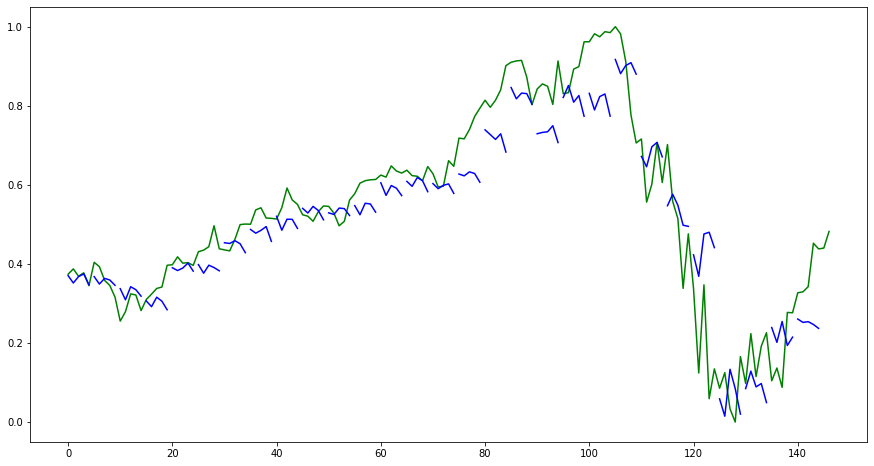

In [0]:
plt.figure(figsize=(15, 8))
plt.plot(y_test_plot, color='g')

for i in range(0, y_test_predict.shape[0], NUM_STEP):
  plt.plot(range(i, i + NUM_STEP), y_test_predict[i], color='b')

plt.show()

Result: The model was able to pull the prediction closer to the actual price compared to the previous model. The model was able to capture the trend better compared to the previous model. LSTM was able to learn the stock trend by itself without the support of technical indicators. However, I still think technical can provide insight into the stock trend. So I will use them as additional input to the model.

## Using technical indicators as additional input for more stock trend information

In [0]:
INPUT_SHAPE_EXTERNAL = (X_external_train.shape[1])

In [0]:
input_layer = Input(shape=(INPUT_SHAPE), 
                    name='lstm_input')

external_input_layer = Input(shape=(INPUT_SHAPE_EXTERNAL), name='external_dense_input')

x = LSTM(32, name='lstm_layer_0', return_sequences=True)(input_layer)
x = Flatten()(x)
x = concatenate((external_input_layer, x))
x = BatchNormalization()(x)
output_layer = Dense(OUTPUT_SHAPE, activation='elu', name='output_layer')(x)

lstm_model = Model(inputs=[input_layer, external_input_layer], outputs=output_layer, name='lstm_model')

lstm_model.compile(loss='mse', optimizer='rmsprop')

history = lstm_model.fit([X_train, X_external_train], y_train, batch_size=64, epochs=120, validation_split=0.3, use_multiprocessing=True)

Epoch 1/120
41/41 [==============================] - 1s 17ms/step - loss: 0.0300 - val_loss: 0.2724
Epoch 2/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0086 - val_loss: 0.2683
Epoch 3/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0064 - val_loss: 0.2724
Epoch 4/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0053 - val_loss: 0.2399
Epoch 5/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.3016
Epoch 6/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0040 - val_loss: 0.2303
Epoch 7/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0036 - val_loss: 0.2631
Epoch 8/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0035 - val_loss: 0.2543
Epoch 9/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 0.2814
Epoch 10/120
41/41 [==============================] - 0s 8ms/step - loss: 0.0029 - val_loss: 0.2025
Epoch 11

In [0]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

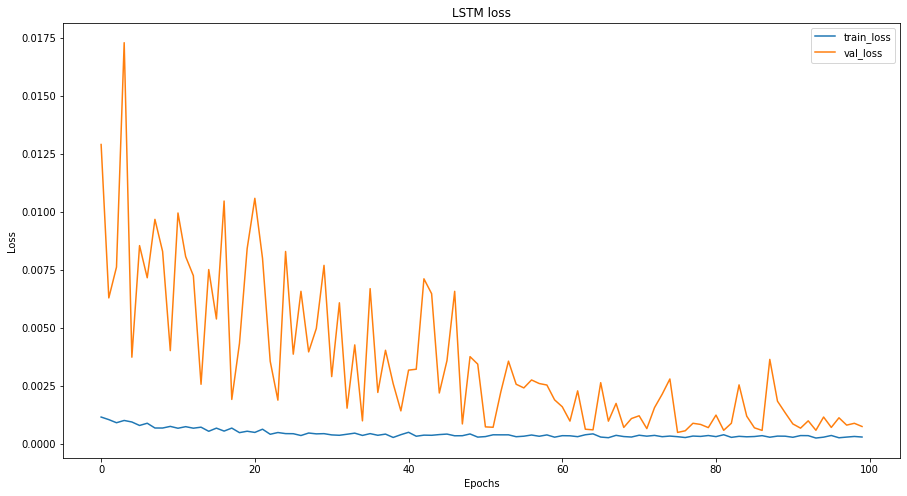

In [0]:
plt.figure(figsize=(15, 8))

plt.plot(train_loss[20:])
plt.plot(val_loss[20:])

plt.title('LSTM loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'])

plt.show()

In [0]:
lstm_model.evaluate((X_test, X_external_test), y_test)

5/5 [==============================] - 0s 3ms/step - loss: 0.0094


0.00938699021935463

In [0]:
y_test_plot = np.concatenate((y_test[:, 0], y_test[-1, 1:]))
y_test_predict = lstm_model.predict((X_test, X_external_test))

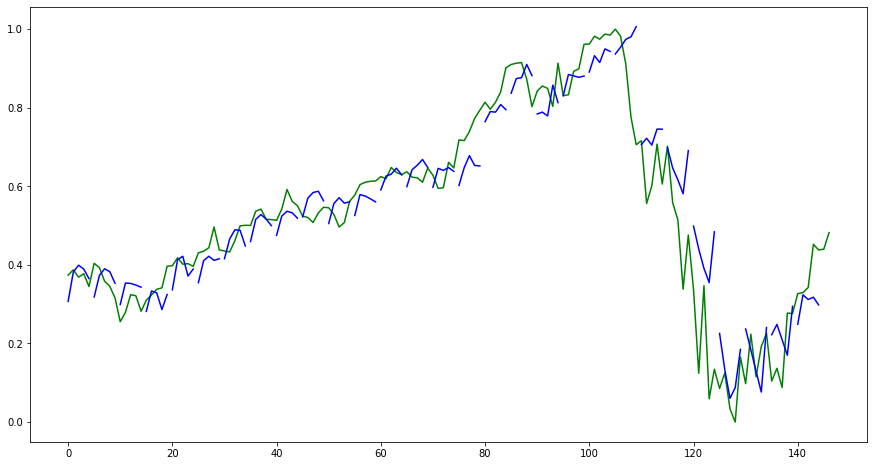

In [0]:
plt.figure(figsize=(15, 8))
plt.plot(y_test_plot, color='g')

for i in range(0, y_test_predict.shape[0], NUM_STEP):
  plt.plot(range(i, i + NUM_STEP), y_test_predict[i], color='b')

plt.show()

Result: compared to the 2nd model, the 3rd model has slightly worse MSE. However, it was able to capture the trend a lot better, still not highly accurate but it still can tell if the trend will go up or down in the next 5 days. This may sound like a forceful conclusion. But on all 3 models so far, the 3rd model was able to produce a certain trend closest to the actual thing. So I will choose this one as the main model.

PLEASE DO NOTE THAT IT IS FAR FROM PERFECT OR PRACTICAL ENOUGH TO USE IN REAL LIFE SCENARIO

# Fine-tuning final model

In [0]:
FEATURE_COL = ['Open', 'High', 'Low', 'Close', 'Volume']
# EXT_FEATURE_COL = ['ma7', 'ma21', '26ema', '12ema', 'MACD', 'std21', 'upper_band21', 'lower_band21', 'ema']
# EXT_FEATURE_COL = ['ma7', 'MACD', 'std21', 'ema']
EXT_FEATURE_COL = ['ma7', 'MACD', 'upper_band21', 'lower_band21', 'ema']
TARGET_COL = ['Close']
LAG_DAYS = 15
NUM_STEP = 5

data_technical_indicators = get_technical_indicators(data)
data_technical_indicators = data_technical_indicators.dropna()
data_technical_indicators = data_technical_indicators.reset_index(drop=True)

train_data, test_data = split_data(data_technical_indicators, FEATURE_COL, EXT_FEATURE_COL, TARGET_COL, train_size=0.96)

train_data_scaled, scalers = scale_data(train_data)
test_data_scaled, _ = scale_data(test_data, scalers=scalers) 

X_train, X_external_train, y_train = split_feature_target(train_data_scaled, LAG_DAYS, NUM_STEP)
X_test, X_external_test, y_test = split_feature_target(test_data_scaled, LAG_DAYS, NUM_STEP)

print(f'[X_train shape: {X_train.shape} - y_train shape: {y_train.shape}]')
print(f'[X_externel_train shape: {X_external_train.shape} - X_externel_test shape: {X_external_test.shape}]')
print(f'[X_test shape: {X_test.shape} - y_test shape: {y_test.shape}]')

[X_train shape: (3741, 15, 5) - y_train shape: (3741, 5, 1)]
[X_externel_train shape: (3741, 5) - X_externel_test shape: (138, 5)]
[X_test shape: (138, 15, 5) - y_test shape: (138, 5, 1)]


In [0]:
INPUT_SHAPE = (LAG_DAYS, len(FEATURE_COL))
INPUT_SHAPE_EXTERNAL = (X_external_train.shape[1])
OUTPUT_SHAPE = (NUM_STEP)

input_layer = Input(shape=(INPUT_SHAPE), 
                    name='lstm_input')

external_input_layer = Input(shape=(INPUT_SHAPE_EXTERNAL), name='external_dense_input')

external_input_layer_dense = BatchNormalization()(external_input_layer)
external_input_layer_dense = Dense(12, activation='relu', name='test')(external_input_layer_dense)
external_input_layer_dense = BatchNormalization()(external_input_layer_dense)

x = LSTM(32, name='lstm_layer_0', kernel_regularizer='l2', return_sequences=True)(input_layer)

x = Flatten()(x)
x = concatenate((external_input_layer_dense, x))

# x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output_layer = Dense(OUTPUT_SHAPE, activation='relu', name='output_layer')(x)
# => understand the trend (lstm connects straight to output => have access to the trend)

lstm_model = Model(inputs=[input_layer, external_input_layer], outputs=output_layer, name='lstm_model')

lstm_model.compile(loss='mse', optimizer='rmsprop')

# lstm_model.summary()

history = lstm_model.fit([X_train, X_external_train], y_train, batch_size=64, epochs=120, validation_split=0.3, use_multiprocessing=True)

Epoch 1/120
41/41 [==============================] - 1s 20ms/step - loss: 0.1045 - val_loss: 0.4629
Epoch 2/120
41/41 [==============================] - 0s 10ms/step - loss: 0.0644 - val_loss: 0.3939
Epoch 3/120
41/41 [==============================] - 0s 10ms/step - loss: 0.0417 - val_loss: 0.3280
Epoch 4/120
41/41 [==============================] - 0s 11ms/step - loss: 0.0288 - val_loss: 0.2724
Epoch 5/120
41/41 [==============================] - 0s 11ms/step - loss: 0.0198 - val_loss: 0.2182
Epoch 6/120
41/41 [==============================] - 0s 11ms/step - loss: 0.0156 - val_loss: 0.2221
Epoch 7/120
41/41 [==============================] - 0s 11ms/step - loss: 0.0126 - val_loss: 0.1973
Epoch 8/120
41/41 [==============================] - 0s 11ms/step - loss: 0.0098 - val_loss: 0.1860
Epoch 9/120
41/41 [==============================] - 0s 11ms/step - loss: 0.0079 - val_loss: 0.1676
Epoch 10/120
41/41 [==============================] - 0s 10ms/step - loss: 0.0063 - val_loss: 0.1523

In [0]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

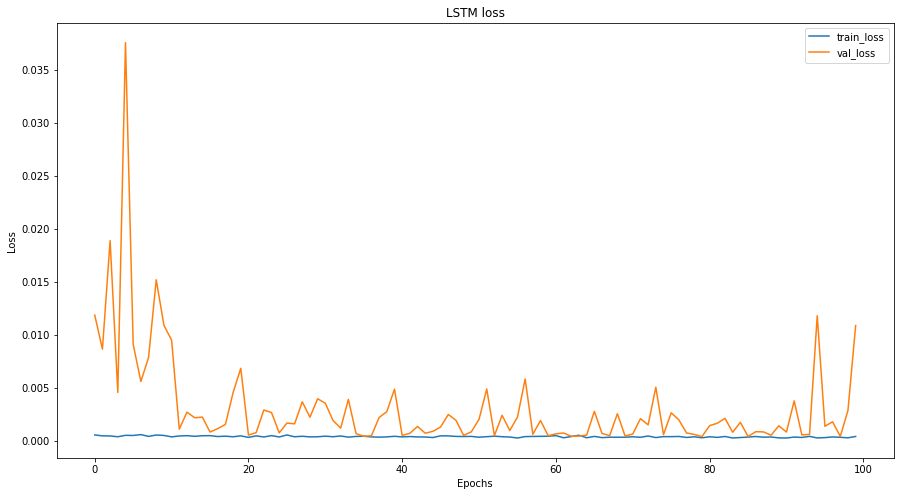

In [0]:
plt.figure(figsize=(15, 8))

plt.plot(train_loss[20:])
plt.plot(val_loss[20:])

plt.title('LSTM loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'])

plt.show()

In [0]:
lstm_model.evaluate((X_test, X_external_test), y_test)

5/5 [==============================] - 0s 3ms/step - loss: 0.0180


0.017984788864850998

In [0]:
y_test_plot = np.concatenate((y_test[:, 0], y_test[-1, 1:]))
y_test_predict = lstm_model.predict((X_test, X_external_test))

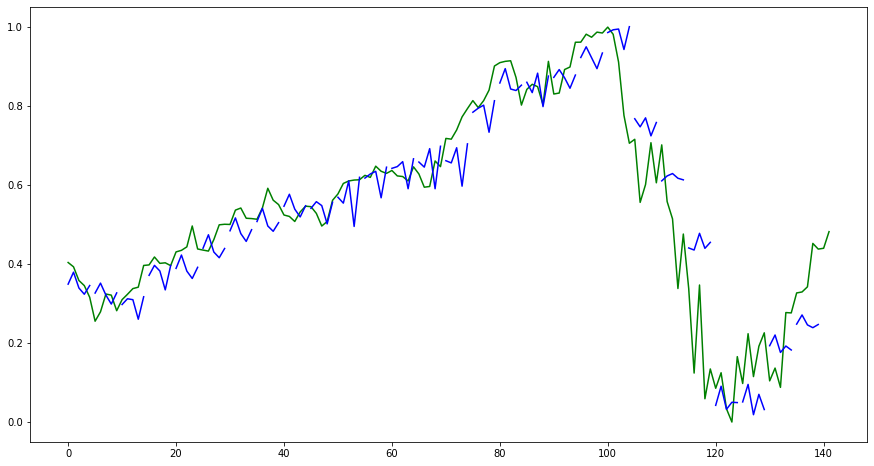

In [0]:
plt.figure(figsize=(15, 8))
plt.plot(y_test_plot, color='g')

for i in range(0, y_test_predict.shape[0], NUM_STEP):
  plt.plot(range(i, i + NUM_STEP), y_test_predict[i], color='b')

plt.show()